# XStoryCloze evaluation

In [1]:
import pandas as pd


def get_dfs(model_names, dataset_name="xstory_cloze"):
    acc_df = pd.DataFrame()
    ppl_cor_df = pd.DataFrame()
    ppl_inc_df = pd.DataFrame()

    for model_name in model_names:
        name = model_name.split("/")[-1]
        metrics_df = pd.read_csv(
            f"../results/{dataset_name}_{name}_metrics.tsv", delimiter="\t"
        )
        acc_df["lang"] = metrics_df["lang"]
        ppl_cor_df["lang"] = metrics_df["lang"]
        ppl_inc_df["lang"] = metrics_df["lang"]
        acc_df[name] = metrics_df["acc"]
        ppl_cor_df[name] = metrics_df["ppl_cor"]
        ppl_inc_df[name] = metrics_df["ppl_inc"]

    return acc_df, ppl_cor_df, ppl_inc_df


import matplotlib.pyplot as plt


def plot_df(df, title):
    df.plot.bar()
    plt.title(title)
    plt.xticks(list(range(len(df["lang"]))), df["lang"], rotation="vertical")
    plt.show()


def plot_size_df(df, model_sizes, model_names, title):
    dft = df.set_index("lang").T
    dft["size"] = model_sizes
    dft.plot(x="size", marker="o")
    plt.title(title)
    plt.xticks(model_sizes, model_sizes, rotation="vertical")


## GPT3 EUS

In [2]:
gpt3_eus_model_names = [
    "/gscratch4/users/aormazabal024/GPT3_EUS/to_share/spm_model",
    "/gscratch4/users/aormazabal024/GPT3_EUS/to_share/bpe_model",
]
gpt3_eus_model_sizes = [0.3, 0.3]
gpt3_eus_names = [name.split("/")[-1] for name in gpt3_eus_model_names]
acc_df_gpt3_eus, ppl_cor_df_gpt3_eus, ppl_inc_df_gpt3_eus = get_dfs(
    gpt3_eus_model_names
)


In [3]:
display(acc_df_gpt3_eus)
display(ppl_cor_df_gpt3_eus)
display(ppl_inc_df_gpt3_eus)


,lang,spm_model,bpe_model
0,eu,54.7,50.6
1,avg,54.7,50.6


,lang,spm_model,bpe_model
0,eu,55.63,20.34
1,avg,55.63,20.34


,lang,spm_model,bpe_model
0,eu,57.15,20.39
1,avg,57.15,20.39


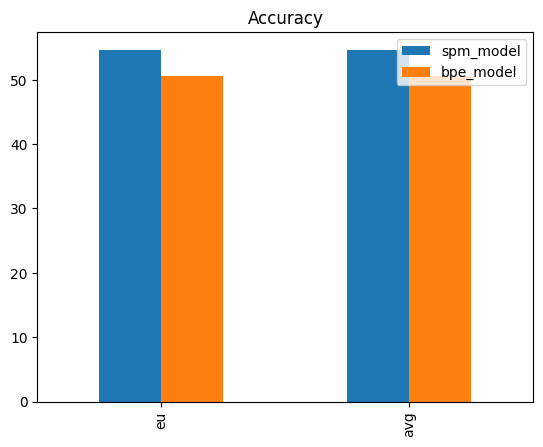

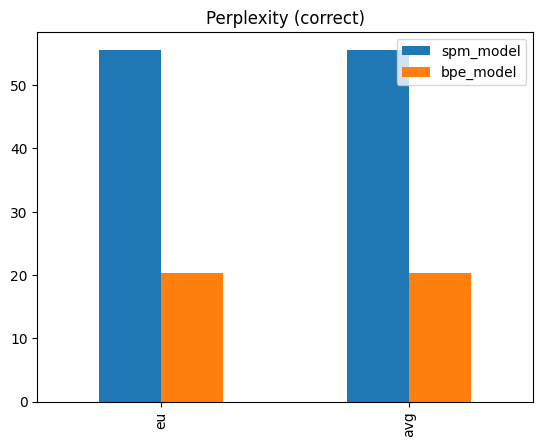

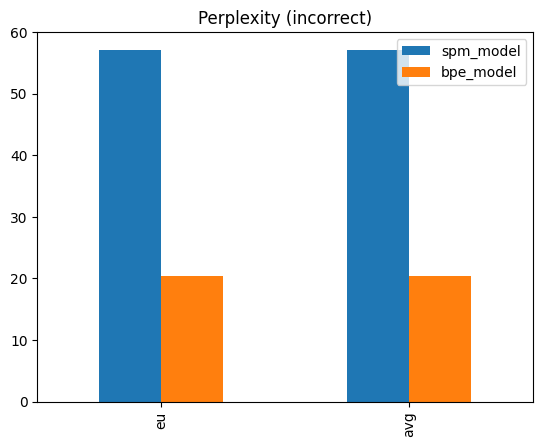

In [4]:
plot_df(acc_df_gpt3_eus, "Accuracy")
plot_df(ppl_cor_df_gpt3_eus, "Perplexity (correct)")
plot_df(ppl_inc_df_gpt3_eus, "Perplexity (incorrect)")


## mGPT

In [5]:
mgpt_model_names = ["sberbank-ai/mGPT"]
mgpt_model_sizes = [1.3]
mgpt_names = [name.split("/")[-1] for name in mgpt_model_names]
acc_df_mgpt, ppl_cor_df_mgpt, ppl_inc_df_mgpt = get_dfs(mgpt_model_names)


In [6]:
metrics_df = pd.read_csv(f"../results/xstory_cloze_mGPT_metrics.tsv", delimiter="\t")
metrics_df


,lang,acc,ppl_cor,ppl_inc
0,en,63.2,20.67,21.80
1,ru,61.3,12.86,13.30
2,zh,57.0,17.21,17.63
3,es,58.8,17.40,18.01
4,ar,53.3,24.25,24.61
5,hi,56.5,4.42,4.48
6,id,58.8,19.37,20.06
7,te,58.2,3.57,3.63
8,sw,57.8,12.47,12.82
9,eu,55.9,16.91,17.28


In [7]:
metrics_mt_df = pd.read_csv(
    f"../results/xstory_cloze_mt_nllb-3B_mGPT_metrics.tsv", delimiter="\t"
)
metrics_mt_df


,lang,acc,ppl_cor,ppl_inc
0,en,63.2,20.67,21.80
1,ru,63.5,18.39,19.42
2,zh,62.5,18.94,19.92
3,es,63.9,19.62,20.62
4,ar,61.0,21.12,22.13
5,hi,60.0,20.74,21.76
6,id,59.7,21.49,22.45
7,te,60.9,22.48,23.45
8,sw,61.3,20.87,21.86
9,eu,61.2,19.41,20.41


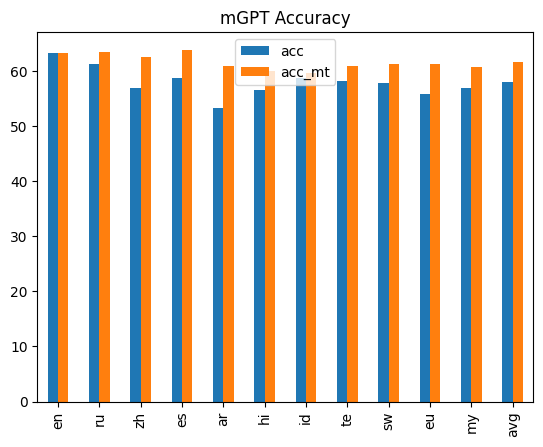

In [8]:
metrics_df["acc_mt"] = metrics_mt_df["acc"]
metrics_df["ppl_cor_mt"] = metrics_mt_df["ppl_cor"]
metrics_df["ppl_inc_mt"] = metrics_mt_df["ppl_inc"]
plot_df(metrics_df[["lang", "acc", "acc_mt"]], "mGPT Accuracy")


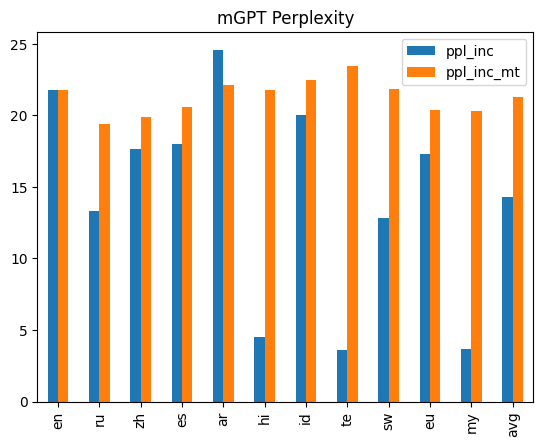

In [9]:
plot_df(metrics_df[["lang", "ppl_inc", "ppl_inc_mt"]], "mGPT Perplexity")


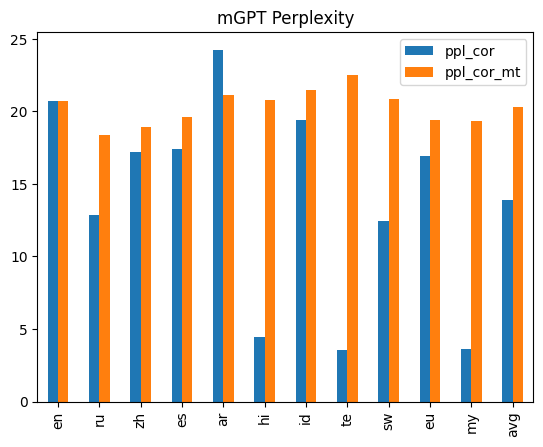

In [10]:
plot_df(metrics_df[["lang", "ppl_cor", "ppl_cor_mt"]], "mGPT Perplexity")


## XGLM

In [11]:
xglm_model_names = [
    "facebook/xglm-564M",
    "facebook/xglm-1.7B",
    "facebook/xglm-2.9B",
    "facebook/xglm-4.5B",
    "facebook/xglm-7.5B",
]
xglm_model_sizes = [0.6, 1.7, 2.9, 4.5, 7.5]
xglm_names = [name.split("/")[-1] for name in xglm_model_names]
acc_df_xglm, ppl_cor_df_xglm, ppl_inc_df_xglm = get_dfs(xglm_model_names)


In [12]:
display(acc_df_xglm)
display(ppl_cor_df_xglm)
display(ppl_inc_df_xglm)


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,61.3,66.6,69.6,72.1,73.7
1,ru,59.5,62.8,67.2,66.8,69.0
2,zh,56.3,60.2,64.1,64.4,65.9
3,es,56.5,60.6,64.6,66.4,66.7
4,ar,53.9,55.6,57.7,57.7,58.5
5,hi,54.2,56.8,59.4,57.1,59.5
6,id,56.8,61.5,65.5,65.6,68.0
7,te,56.9,58.4,59.4,58.7,60.6
8,sw,56.4,60.8,60.8,60.1,63.3
9,eu,55.1,57.5,58.4,55.3,61.7


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,21.41,17.18,15.57,14.67,14.43
1,ru,21.55,16.51,15.07,14.10,13.86
2,zh,33.26,25.65,22.72,21.26,20.70
3,es,24.74,18.75,16.70,15.69,15.10
4,ar,44.25,31.90,26.17,27.32,23.48
5,hi,23.14,18.21,16.33,20.63,15.31
6,id,42.47,31.93,28.09,28.64,25.71
7,te,29.10,24.68,20.60,26.38,18.81
8,sw,47.24,33.23,28.51,46.27,25.16
9,eu,34.55,23.12,20.18,104.26,18.94


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,22.50,18.41,16.91,16.04,15.83
1,ru,22.32,17.34,16.02,15.01,14.83
2,zh,34.08,26.61,23.86,22.41,21.92
3,es,25.50,19.58,17.64,16.65,16.10
4,ar,44.79,32.59,26.96,28.11,24.31
5,hi,23.48,18.64,16.85,21.24,15.84
6,id,44.09,33.73,30.13,30.72,27.88
7,te,29.89,25.52,21.42,27.34,19.62
8,sw,48.73,34.70,29.92,48.24,26.57
9,eu,35.48,23.84,20.93,107.33,19.77


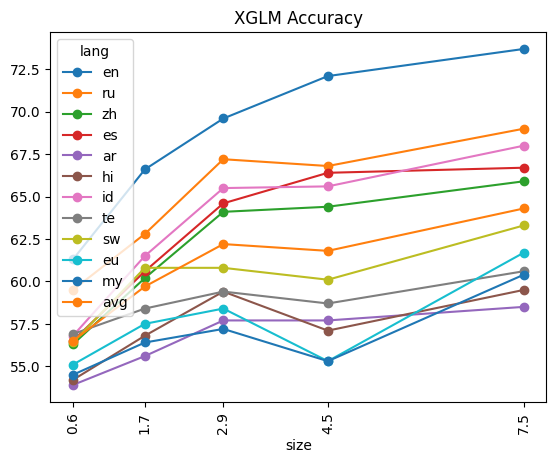

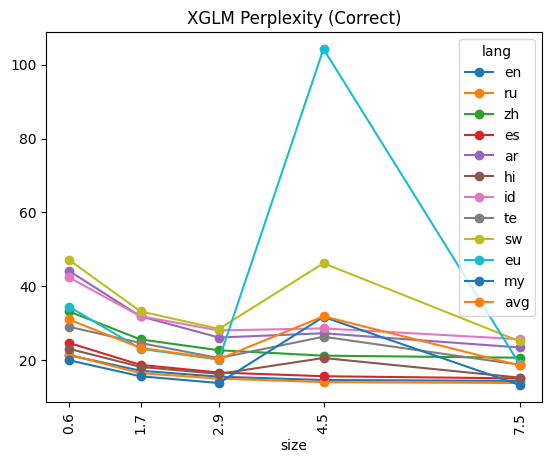

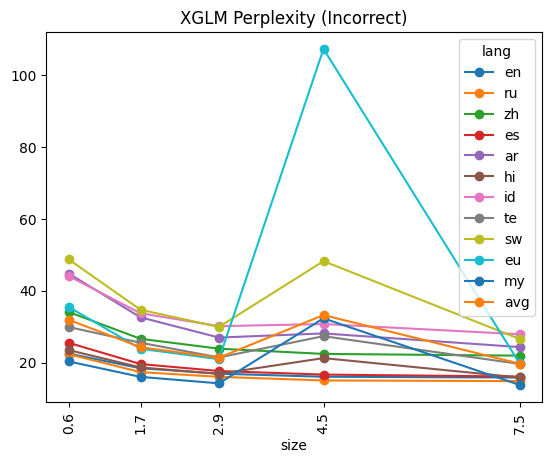

In [13]:
plot_size_df(acc_df_xglm, xglm_model_sizes, xglm_names, "XGLM Accuracy")
plot_size_df(ppl_cor_df_xglm, xglm_model_sizes, xglm_names, "XGLM Perplexity (Correct)")
plot_size_df(
    ppl_inc_df_xglm, xglm_model_sizes, xglm_names, "XGLM Perplexity (Incorrect)"
)


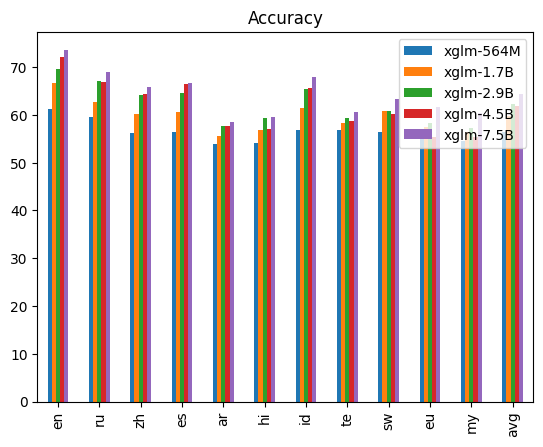

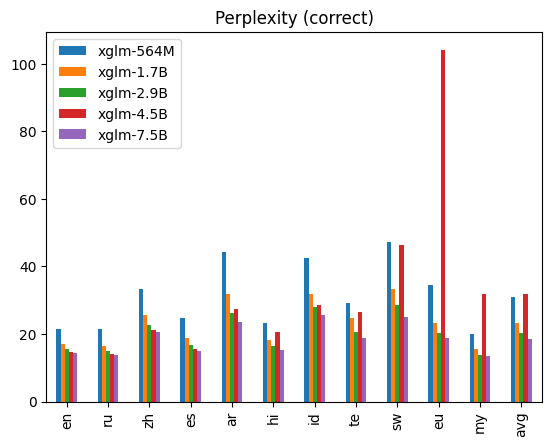

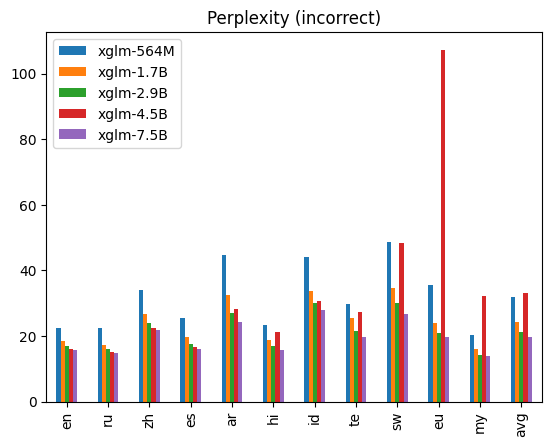

In [14]:
plot_df(acc_df_xglm, "Accuracy")
plot_df(ppl_cor_df_xglm, "Perplexity (correct)")
plot_df(ppl_inc_df_xglm, "Perplexity (incorrect)")


## BLOOM

In [15]:
bloom_model_names = [
    "bigscience/bloom-560m",
    "bigscience/bloom-1b1",
    "bigscience/bloom-1b7",
    "bigscience/bloom-3b",
    "bigscience/bloom-7b1",
]
bloom_names = [name.split("/")[-1] for name in bloom_model_names]
bloom_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1]
acc_df_bloom, ppl_cor_df_bloom, ppl_inc_df_bloom = get_dfs(bloom_model_names)


In [16]:
display(acc_df_bloom)
display(ppl_cor_df_bloom)
display(ppl_inc_df_bloom)


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,64.1,67.4,70.0,72.1,74.9
1,ru,55.3,54.3,56.7,57.7,59.2
2,zh,58.8,63.3,65.0,67.3,69.4
3,es,58.7,61.3,64.3,67.0,70.1
4,ar,52.7,56.5,56.0,59.6,62.5
5,hi,54.3,56.7,57.8,58.6,62.7
6,id,56.9,61.8,62.9,66.8,69.4
7,te,55.2,55.3,56.0,58.5,57.5
8,sw,52.7,53.7,57.7,58.0,59.2
9,eu,53.8,53.8,55.7,57.2,59.0


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,25.17,21.03,18.82,16.70,14.87
1,ru,27.34,22.23,17.14,14.61,11.75
2,zh,50.50,41.78,36.88,33.22,29.73
3,es,23.78,20.01,17.83,16.09,14.66
4,ar,61.01,47.04,40.49,35.01,30.16
5,hi,36.25,30.39,25.89,23.60,20.80
6,id,421.08,49.98,42.55,35.84,31.89
7,te,166.78,115.38,64.08,63.15,50.55
8,sw,513.69,356.80,175.12,131.60,88.72
9,eu,116.24,88.00,60.89,50.50,41.14


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,26.79,22.58,20.45,18.33,16.53
1,ru,28.00,22.70,17.57,15.02,12.14
2,zh,53.13,44.53,39.61,36.03,32.65
3,es,24.75,20.99,18.92,17.24,15.88
4,ar,62.20,48.42,42.00,36.57,31.93
5,hi,37.08,31.29,26.75,24.59,21.81
6,id,443.79,52.86,45.52,38.68,34.95
7,te,171.31,118.89,66.10,65.51,52.52
8,sw,529.58,365.86,182.30,137.75,93.63
9,eu,118.98,90.22,62.87,52.24,43.03


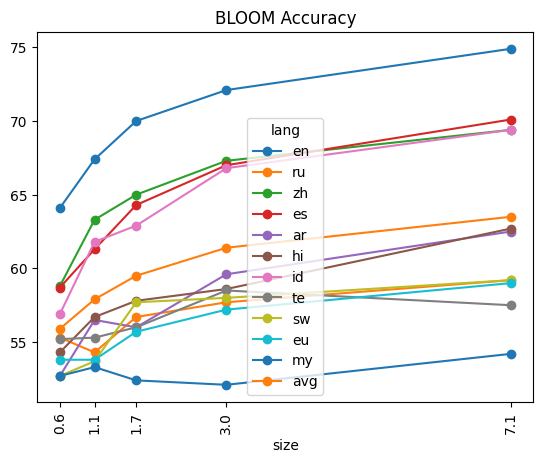

In [17]:
plot_size_df(acc_df_bloom, bloom_model_sizes, bloom_names, "BLOOM Accuracy")


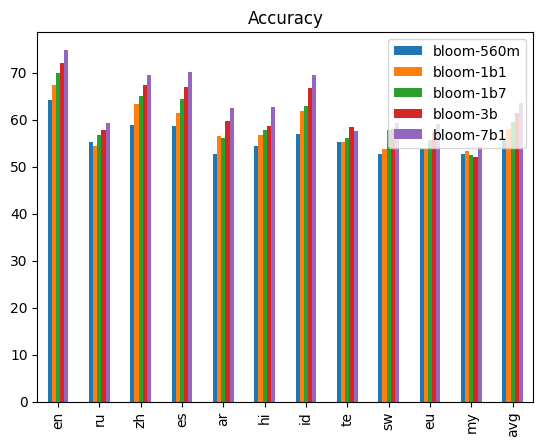

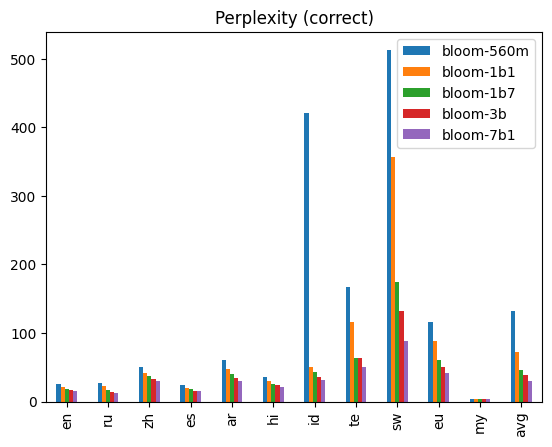

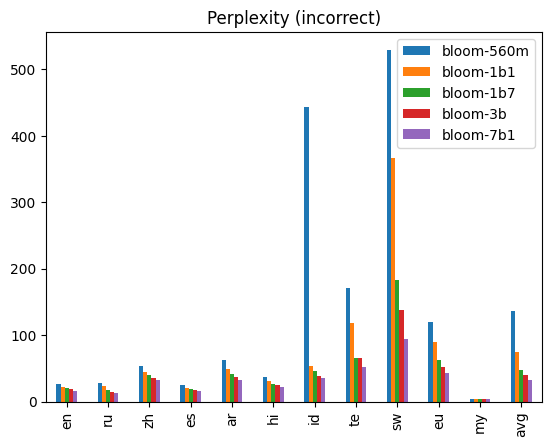

In [18]:
plot_df(acc_df_bloom, "Accuracy")
plot_df(ppl_cor_df_bloom, "Perplexity (correct)")
plot_df(ppl_inc_df_bloom, "Perplexity (incorrect)")


## BLOOMZ

In [19]:
bloomz_model_names = [
    "bigscience/bloomz-560m",
    "bigscience/bloomz-1b1",
    "bigscience/bloomz-1b7",
    "bigscience/bloomz-3b",
    "bigscience/bloomz-7b1",
    "bigscience/bloomz-7b1-mt",
    "bigscience/bloomz-7b1-p3",
]
bloomz_names = [name.split("/")[-1] for name in bloomz_model_names]
bloomz_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1, 7.1, 7.1]
acc_df_bloomz, ppl_cor_df_bloomz, ppl_inc_df_bloomz = get_dfs(bloomz_model_names)


In [20]:
display(acc_df_bloomz)
display(ppl_cor_df_bloomz)
display(ppl_inc_df_bloomz)


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,66.0,68.8,72.4,74.4,78.0,78.4,78.1
1,ru,54.9,53.5,55.1,56.2,56.8,57.0,59.1
2,zh,62.3,64.3,63.1,62.9,66.8,67.6,73.2
3,es,60.0,62.3,60.4,58.3,68.0,67.5,69.2
4,ar,55.2,58.1,56.3,56.3,60.8,62.1,66.5
5,hi,54.6,57.4,55.1,55.3,59.6,57.8,65.8
6,id,50.6,62.9,57.9,58.2,61.5,61.2,67.5
7,te,52.5,55.0,52.0,52.8,55.3,54.5,59.2
8,sw,53.4,53.5,52.4,53.8,54.9,56.2,59.2
9,eu,47.1,52.0,47.2,45.9,52.9,51.1,59.1


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,24.69,20.04,18.57,16.90,15.18,15.02,15.97
1,ru,336.42,29.06,275.05,71.41,35.33,34.19,14.36
2,zh,55.72,39.26,201.04,1328.52,229.26,185.35,71.93
3,es,30.23,19.97,68.04,111.60,33.56,45.88,21.92
4,ar,457.17,46.39,323.19,615.79,110.64,106.18,58.39
5,hi,645.07,32.66,4906.12,4065.63,469.22,1616.87,46.36
6,id,27358560.60,64.19,3687.49,3650.53,2574.75,4844.56,66.11
7,te,5606.46,97.41,28257.47,27149.30,3633.10,8788.37,76.16
8,sw,1426.43,349.50,1806.27,3225.77,2088.35,2541.11,166.68
9,eu,6841.67,288.67,28747.34,22186.82,4138.25,6434.85,85.29


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,26.46,21.74,20.43,18.80,17.19,17.04,18.37
1,ru,346.63,29.61,283.78,73.54,36.61,35.47,14.86
2,zh,59.45,42.26,219.60,1458.29,257.09,208.04,82.36
3,es,31.57,21.09,72.31,117.73,36.59,50.18,24.20
4,ar,478.23,48.25,337.64,635.47,117.52,113.56,63.32
5,hi,661.11,33.87,5117.14,4222.96,496.04,1710.25,49.56
6,id,23056264.00,68.18,3920.80,3851.31,2809.18,5328.30,73.53
7,te,5690.15,99.97,28922.91,27755.74,3784.70,9069.93,80.02
8,sw,1459.68,356.69,1848.71,3316.85,2175.87,2663.81,176.53
9,eu,6689.80,293.84,28074.24,21626.92,4213.08,6514.98,90.57


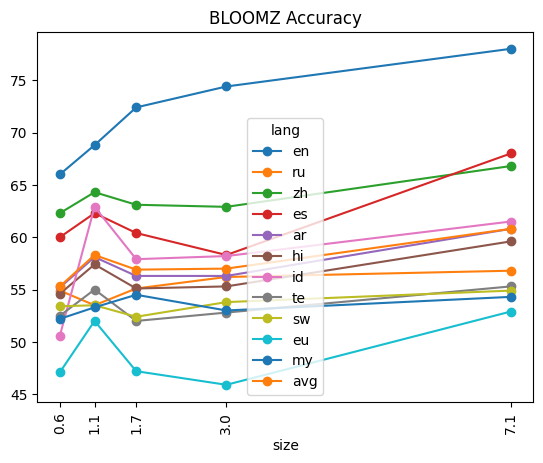

In [21]:
plot_size_df(
    acc_df_bloomz[
        ["lang", "bloomz-560m", "bloomz-1b1", "bloomz-1b7", "bloomz-3b", "bloomz-7b1"]
    ],
    bloomz_model_sizes[:-2],
    bloomz_names[:-2],
    "BLOOMZ Accuracy",
)


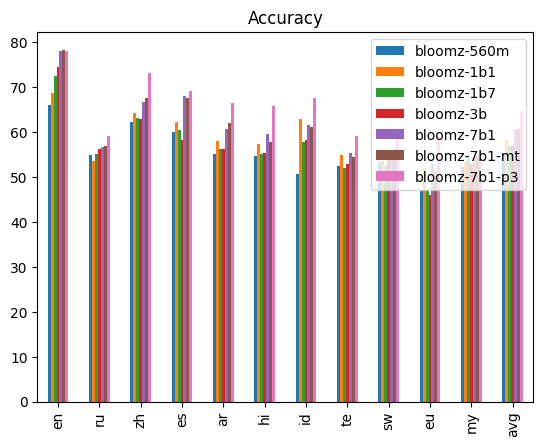

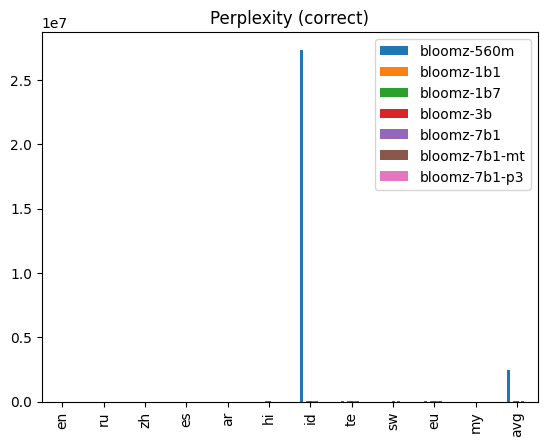

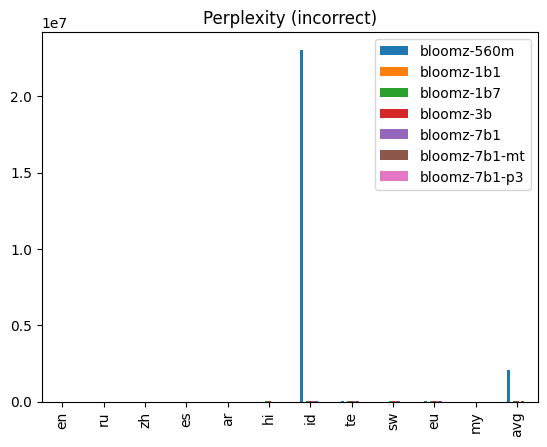

In [22]:
plot_df(acc_df_bloomz, "Accuracy")
plot_df(ppl_cor_df_bloomz, "Perplexity (correct)")
plot_df(ppl_inc_df_bloomz, "Perplexity (incorrect)")


## Summary EU

In [23]:
# summarize the eu language results for all models
model_sizes = (
    gpt3_eus_model_sizes
    + mgpt_model_sizes
    + xglm_model_sizes
    + bloom_model_sizes
    + bloomz_model_sizes
)

model_names = (
    gpt3_eus_names
    + mgpt_names
    + xglm_names
    + bloom_names
    + bloomz_names
)

models = [name.split("-")[0] for name in model_names]
models[0] = "gpt3-eus-spm"
models[1] = "gpt3-eus-bpe"
models[-2] = "bloomz-mt"
models[-1] = "bloomz-p3"

acc_dfs = [acc_df_gpt3_eus, acc_df_mgpt, acc_df_xglm, acc_df_bloom, acc_df_bloomz]
ppl_cor_dfs = [
    ppl_cor_df_gpt3_eus,
    ppl_cor_df_mgpt,
    ppl_cor_df_xglm,
    ppl_cor_df_bloom,
    ppl_cor_df_bloomz,
]
ppl_inc_dfs = [
    ppl_inc_df_gpt3_eus,
    ppl_inc_df_mgpt,
    ppl_inc_df_xglm,
    ppl_inc_df_bloom,
    ppl_inc_df_bloomz,
]

acc_eu, ppl_cor_eu, ppl_inc_eu = [], [], []
for df in acc_dfs:
    acc_eu.extend(df.loc[df["lang"] == "eu"].values[0][1:])
for df in ppl_cor_dfs:
    ppl_cor_eu.extend(df.loc[df["lang"] == "eu"].values[0][1:])
for df in ppl_inc_dfs:
    ppl_inc_eu.extend(df.loc[df["lang"] == "eu"].values[0][1:])

results_eu_df = pd.DataFrame({"model_name": model_names, "model": models, "size": model_sizes, "acc": acc_eu, "ppl_cor": ppl_cor_eu, "ppl_inc": ppl_inc_eu})

In [24]:
results_eu_df

,model_name,model,size,acc,ppl_cor,ppl_inc
0,spm_model,gpt3-eus-spm,0.3,54.7,55.63,57.15
1,bpe_model,gpt3-eus-bpe,0.3,50.6,20.34,20.39
2,mGPT,mGPT,1.3,55.9,16.91,17.28
3,xglm-564M,xglm,0.6,55.1,34.55,35.48
4,xglm-1.7B,xglm,1.7,57.5,23.12,23.84
5,xglm-2.9B,xglm,2.9,58.4,20.18,20.93
6,xglm-4.5B,xglm,4.5,55.3,104.26,107.33
7,xglm-7.5B,xglm,7.5,61.7,18.94,19.77
8,bloom-560m,bloom,0.6,53.8,116.24,118.98
9,bloom-1b1,bloom,1.1,53.8,88.00,90.22


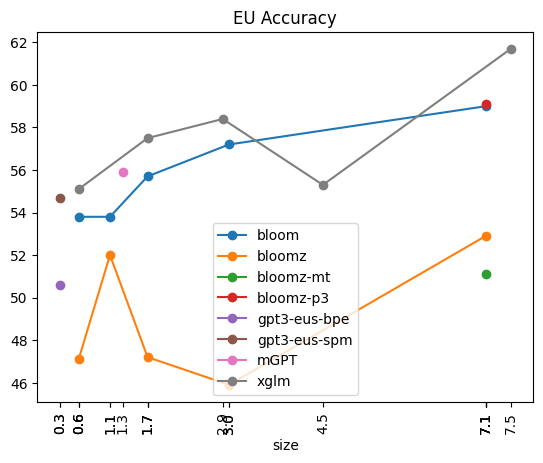

In [25]:
results_eu_df.set_index("size", inplace=True)
results_eu_df.groupby("model")["acc"].plot(x="size", y="acc", title="EU Accuracy", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

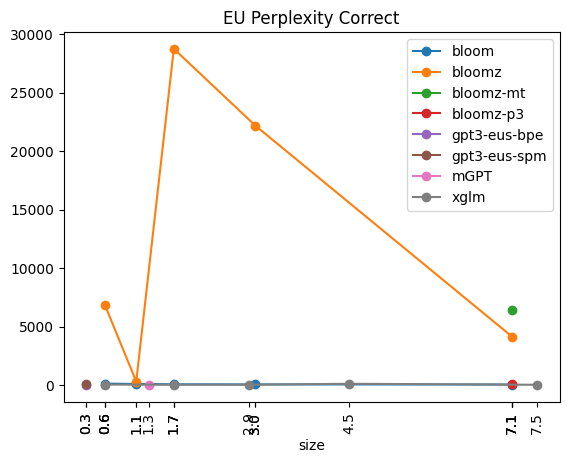

In [26]:
results_eu_df.groupby("model")["ppl_cor"].plot(x="size", y="ppl_cor", title="EU Perplexity Correct", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

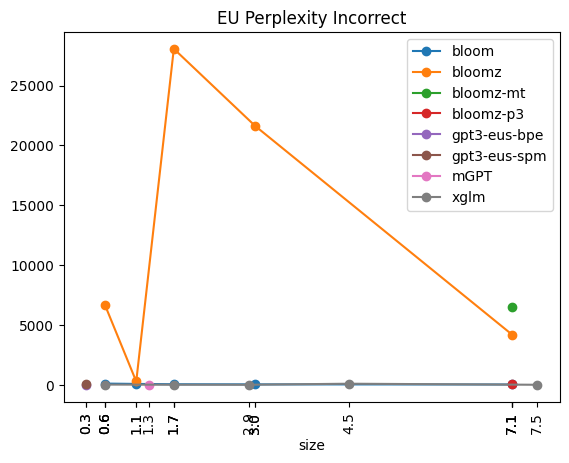

In [27]:
results_eu_df.groupby("model")["ppl_inc"].plot(x="size", y="ppl_inc", title="EU Perplexity Incorrect", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

## Summary EN

In [28]:
# summarize the eu language results for all models
model_sizes = (
    mgpt_model_sizes
    + xglm_model_sizes
    + bloom_model_sizes
    + bloomz_model_sizes
)

model_names = (
    mgpt_names
    + xglm_names
    + bloom_names
    + bloomz_names
)

models = [name.split("-")[0] for name in model_names]
models[-2] = "bloomz-mt"
models[-1] = "bloomz-p3"

acc_dfs = [acc_df_mgpt, acc_df_xglm, acc_df_bloom, acc_df_bloomz]
ppl_cor_dfs = [
    ppl_cor_df_mgpt,
    ppl_cor_df_xglm,
    ppl_cor_df_bloom,
    ppl_cor_df_bloomz,
]
ppl_inc_dfs = [
    ppl_inc_df_mgpt,
    ppl_inc_df_xglm,
    ppl_inc_df_bloom,
    ppl_inc_df_bloomz,
]

acc_eu, ppl_cor_eu, ppl_inc_eu = [], [], []
for df in acc_dfs:
    acc_eu.extend(df.loc[df["lang"] == "en"].values[0][1:])
for df in ppl_cor_dfs:
    ppl_cor_eu.extend(df.loc[df["lang"] == "en"].values[0][1:])
for df in ppl_inc_dfs:
    ppl_inc_eu.extend(df.loc[df["lang"] == "en"].values[0][1:])

results_en_df = pd.DataFrame({"model_name": model_names, "model": models, "size": model_sizes, "acc": acc_eu, "ppl_cor": ppl_cor_eu, "ppl_inc": ppl_inc_eu})

In [29]:
results_en_df

,model_name,model,size,acc,ppl_cor,ppl_inc
0,mGPT,mGPT,1.3,63.2,20.67,21.80
1,xglm-564M,xglm,0.6,61.3,21.41,22.50
2,xglm-1.7B,xglm,1.7,66.6,17.18,18.41
3,xglm-2.9B,xglm,2.9,69.6,15.57,16.91
4,xglm-4.5B,xglm,4.5,72.1,14.67,16.04
5,xglm-7.5B,xglm,7.5,73.7,14.43,15.83
6,bloom-560m,bloom,0.6,64.1,25.17,26.79
7,bloom-1b1,bloom,1.1,67.4,21.03,22.58
8,bloom-1b7,bloom,1.7,70.0,18.82,20.45
9,bloom-3b,bloom,3.0,72.1,16.70,18.33


In [30]:
results_en_df.set_index("size", inplace=True)

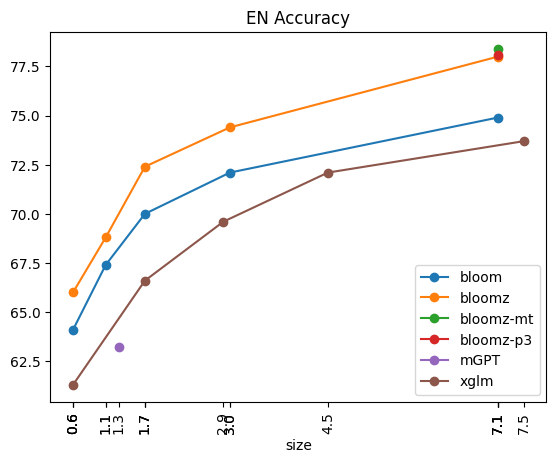

In [31]:
results_en_df.groupby("model")["acc"].plot(x="size", y="acc", title="EN Accuracy", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

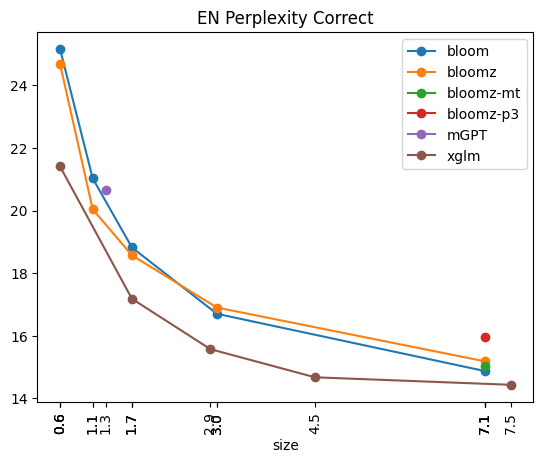

In [32]:
results_en_df.groupby("model")["ppl_cor"].plot(x="size", y="ppl_cor", title="EN Perplexity Correct", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

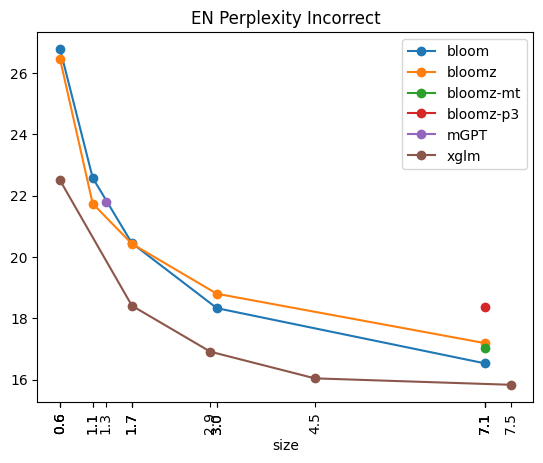

In [33]:
results_en_df.groupby("model")["ppl_inc"].plot(x="size", y="ppl_inc", title="EN Perplexity Incorrect", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

## Summary AVG

In [34]:
# summarize the eu language results for all models
model_sizes = (
    mgpt_model_sizes
    + xglm_model_sizes
    + bloom_model_sizes
    + bloomz_model_sizes
)

model_names = (
    mgpt_names
    + xglm_names
    + bloom_names
    + bloomz_names
)

models = [name.split("-")[0] for name in model_names]
models[-2] = "bloomz-mt"
models[-1] = "bloomz-p3"

acc_dfs = [acc_df_mgpt, acc_df_xglm, acc_df_bloom, acc_df_bloomz]
ppl_cor_dfs = [
    ppl_cor_df_mgpt,
    ppl_cor_df_xglm,
    ppl_cor_df_bloom,
    ppl_cor_df_bloomz,
]
ppl_inc_dfs = [
    ppl_inc_df_mgpt,
    ppl_inc_df_xglm,
    ppl_inc_df_bloom,
    ppl_inc_df_bloomz,
]

acc_eu, ppl_cor_eu, ppl_inc_eu = [], [], []
for df in acc_dfs:
    acc_eu.extend(df.loc[df["lang"] == "avg"].values[0][1:])
for df in ppl_cor_dfs:
    ppl_cor_eu.extend(df.loc[df["lang"] == "avg"].values[0][1:])
for df in ppl_inc_dfs:
    ppl_inc_eu.extend(df.loc[df["lang"] == "avg"].values[0][1:])

results_avg_df = pd.DataFrame({"model_name": model_names, "model": models, "size": model_sizes, "acc": acc_eu, "ppl_cor": ppl_cor_eu, "ppl_inc": ppl_inc_eu})

In [35]:
results_avg_df

,model_name,model,size,acc,ppl_cor,ppl_inc
0,mGPT,mGPT,1.3,58.0,13.89,14.30
1,xglm-564M,xglm,0.6,56.5,31.07,31.92
2,xglm-1.7B,xglm,1.7,59.7,23.35,24.27
3,xglm-2.9B,xglm,2.9,62.2,20.34,21.35
4,xglm-4.5B,xglm,4.5,61.8,31.91,33.22
5,xglm-7.5B,xglm,7.5,64.3,18.62,19.68
6,bloom-560m,bloom,0.6,55.9,131.44,136.33
7,bloom-1b1,bloom,1.1,57.9,72.40,74.74
8,bloom-1b7,bloom,1.7,59.5,45.73,47.77
9,bloom-3b,bloom,3.0,61.4,38.50,40.47


In [36]:
results_avg_df.set_index("size", inplace=True)

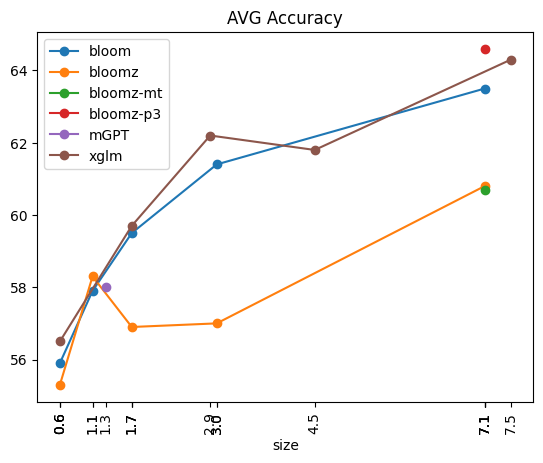

In [37]:
results_avg_df.groupby("model")["acc"].plot(x="size", y="acc", title="AVG Accuracy", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

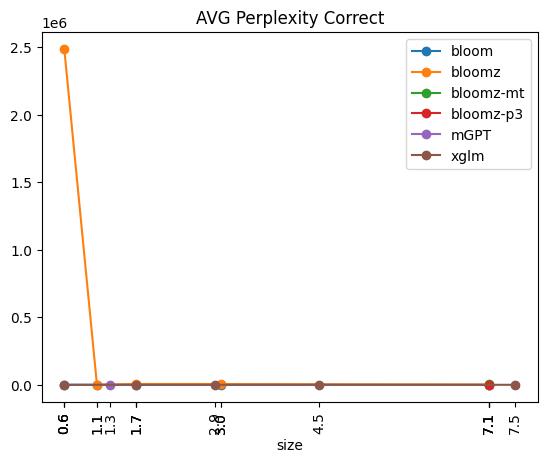

In [38]:
results_avg_df.groupby("model")["ppl_cor"].plot(x="size", y="ppl_cor", title="AVG Perplexity Correct", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

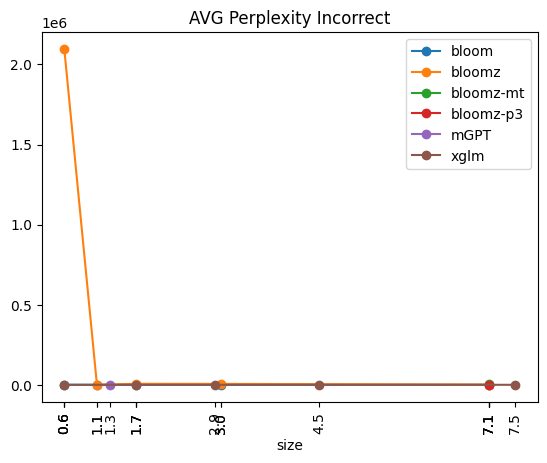

In [39]:
results_avg_df.groupby("model")["ppl_inc"].plot(x="size", y="ppl_inc", title="AVG Perplexity Incorrect", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

# XStoryCloze evaluation MT

## mGPT

In [40]:
mgpt_model_names = ["sberbank-ai/mGPT"]
mgpt_model_sizes = [1.3]
mgpt_names = [name.split("/")[-1] for name in mgpt_model_names]
acc_df_mgpt_mt, ppl_cor_df_mgpt_mt, ppl_inc_df_mgpt_mt = get_dfs(mgpt_model_names, "xstory_cloze_mt_nllb-3B")


In [41]:
metrics_df = pd.read_csv(f"../results/xstory_cloze_mGPT_metrics.tsv", delimiter="\t")
metrics_df


,lang,acc,ppl_cor,ppl_inc
0,en,63.2,20.67,21.80
1,ru,61.3,12.86,13.30
2,zh,57.0,17.21,17.63
3,es,58.8,17.40,18.01
4,ar,53.3,24.25,24.61
5,hi,56.5,4.42,4.48
6,id,58.8,19.37,20.06
7,te,58.2,3.57,3.63
8,sw,57.8,12.47,12.82
9,eu,55.9,16.91,17.28


In [42]:
metrics_mt_df = pd.read_csv(
    f"../results/xstory_cloze_mt_nllb-3B_mGPT_metrics.tsv", delimiter="\t"
)
metrics_mt_df


,lang,acc,ppl_cor,ppl_inc
0,en,63.2,20.67,21.80
1,ru,63.5,18.39,19.42
2,zh,62.5,18.94,19.92
3,es,63.9,19.62,20.62
4,ar,61.0,21.12,22.13
5,hi,60.0,20.74,21.76
6,id,59.7,21.49,22.45
7,te,60.9,22.48,23.45
8,sw,61.3,20.87,21.86
9,eu,61.2,19.41,20.41


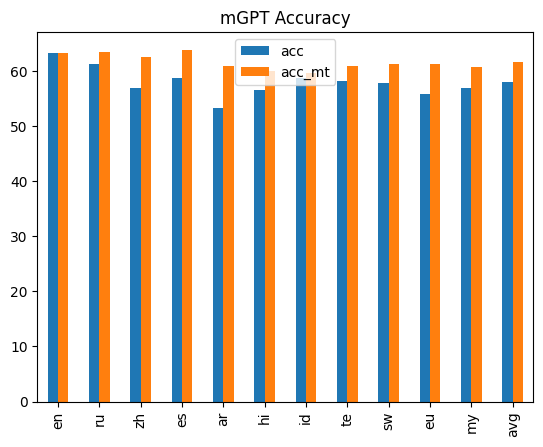

In [43]:
metrics_df["acc_mt"] = metrics_mt_df["acc"]
metrics_df["ppl_cor_mt"] = metrics_mt_df["ppl_cor"]
metrics_df["ppl_inc_mt"] = metrics_mt_df["ppl_inc"]
plot_df(metrics_df[["lang", "acc", "acc_mt"]], "mGPT Accuracy")


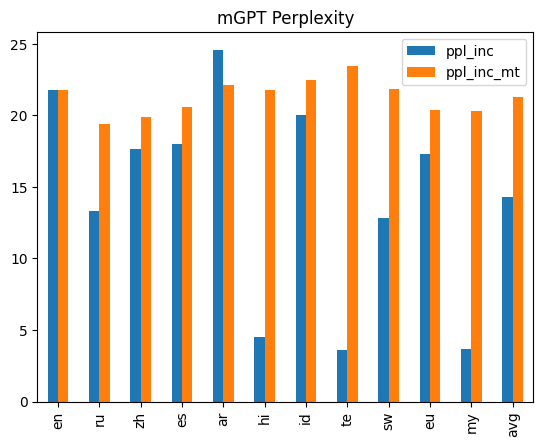

In [44]:
plot_df(metrics_df[["lang", "ppl_inc", "ppl_inc_mt"]], "mGPT Perplexity")


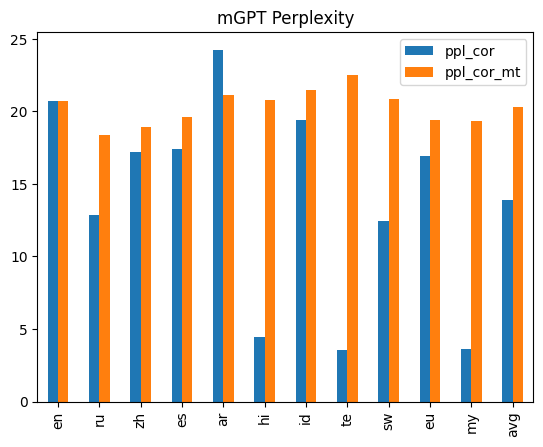

In [45]:
plot_df(metrics_df[["lang", "ppl_cor", "ppl_cor_mt"]], "mGPT Perplexity")


## XGLM

In [46]:
xglm_model_names = [
    "facebook/xglm-564M",
    "facebook/xglm-1.7B",
    "facebook/xglm-2.9B",
    "facebook/xglm-4.5B",
    "facebook/xglm-7.5B",
]
xglm_model_sizes = [0.6, 1.7, 2.9, 4.5, 7.5]
xglm_names = [name.split("/")[-1] for name in xglm_model_names]
acc_df_xglm_mt, ppl_cor_df_xglm_mt, ppl_inc_df_xglm_mt = get_dfs(xglm_model_names, "xstory_cloze_mt_nllb-3B")


In [47]:
display(acc_df_xglm_mt)
display(ppl_cor_df_xglm_mt)
display(ppl_inc_df_xglm_mt)


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,61.3,66.6,69.6,72.1,73.7
1,ru,61.1,66.4,68.6,69.8,69.9
2,zh,61.9,65.2,66.8,68.6,68.8
3,es,62.3,64.7,68.5,68.6,69.8
4,ar,59.5,61.0,63.9,64.5,64.9
5,hi,59.0,63.4,66.2,66.0,66.9
6,id,59.0,62.0,63.5,64.1,66.8
7,te,58.3,60.8,63.3,63.7,65.0
8,sw,59.2,63.3,64.0,64.3,65.7
9,eu,60.8,64.3,66.2,66.0,66.6


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,21.41,17.18,15.57,14.67,14.43
1,ru,18.95,16.15,15.05,14.48,14.33
2,zh,19.99,17.45,16.47,16.02,15.82
3,es,20.43,17.23,16.11,15.47,15.25
4,ar,22.01,18.93,17.82,17.19,16.94
5,hi,21.95,18.81,17.67,17.10,16.88
6,id,22.20,19.05,17.89,17.26,16.99
7,te,23.88,21.14,19.94,19.31,19.14
8,sw,22.11,19.26,18.28,17.69,17.53
9,eu,20.39,17.80,16.94,16.39,16.25


,lang,xglm-564M,xglm-1.7B,xglm-2.9B,xglm-4.5B,xglm-7.5B
0,en,22.50,18.41,16.91,16.04,15.83
1,ru,19.89,17.22,16.24,15.71,15.57
2,zh,20.96,18.54,17.63,17.23,17.08
3,es,21.34,18.29,17.29,16.64,16.47
4,ar,22.93,19.99,18.97,18.37,18.15
5,hi,22.89,19.91,18.92,18.35,18.13
6,id,23.05,20.09,19.01,18.40,18.19
7,te,24.67,22.12,21.06,20.46,20.35
8,sw,23.05,20.34,19.43,18.88,18.74
9,eu,21.29,18.84,18.07,17.54,17.43


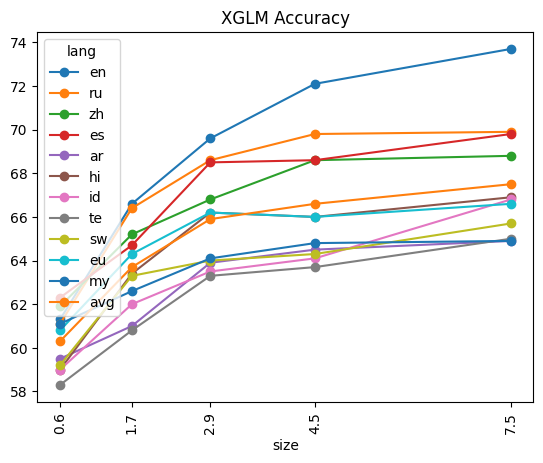

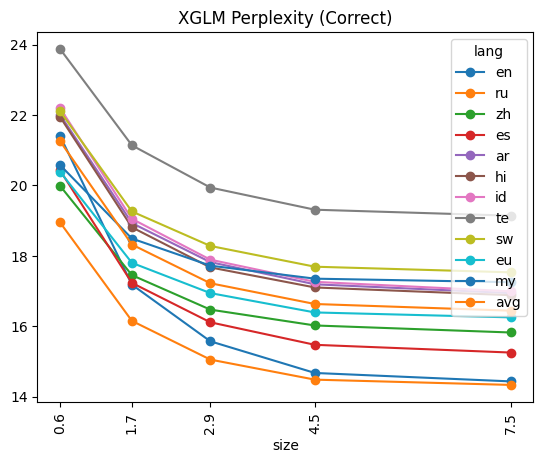

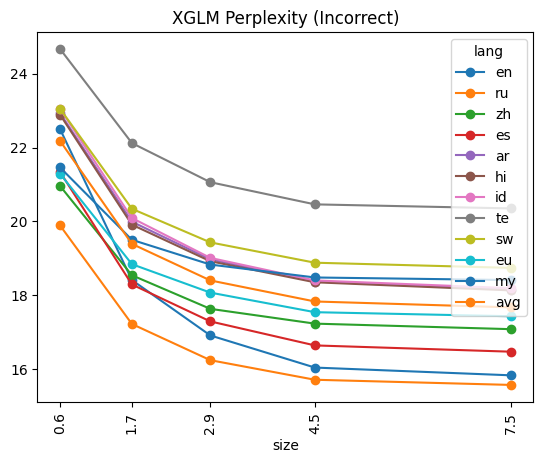

In [48]:
plot_size_df(acc_df_xglm_mt, xglm_model_sizes, xglm_names, "XGLM MT Accuracy")
plot_size_df(ppl_cor_df_xglm_mt, xglm_model_sizes, xglm_names, "XGLM MT Perplexity (Correct)")
plot_size_df(ppl_inc_df_xglm_mt, xglm_model_sizes, xglm_names, "XGLM MT Perplexity (Incorrect)")


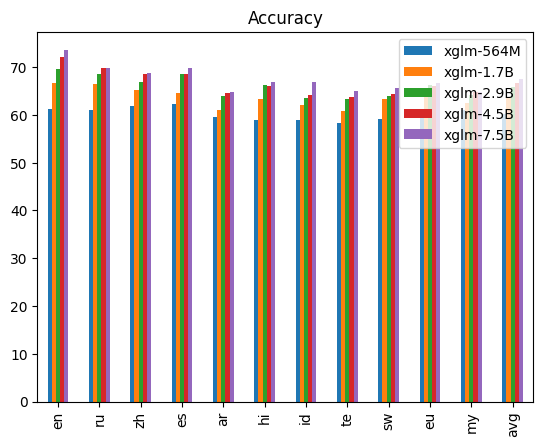

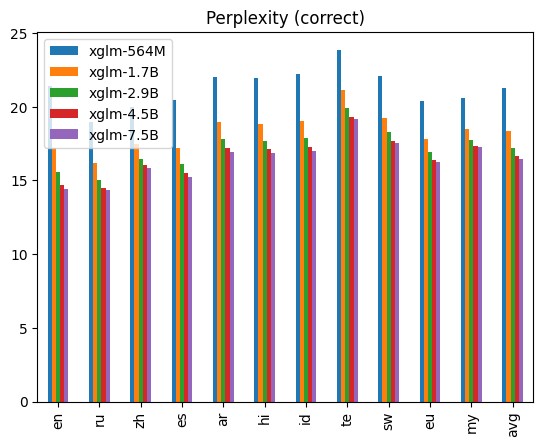

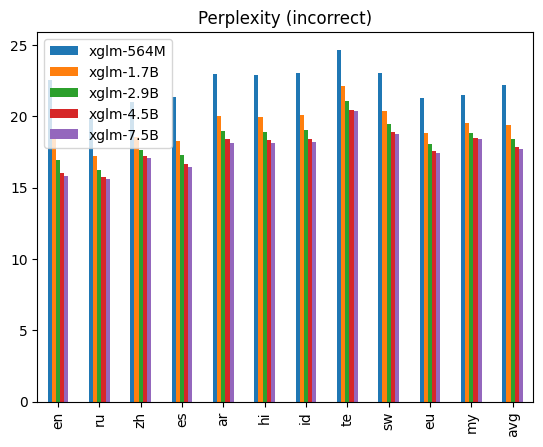

In [49]:
plot_df(acc_df_xglm_mt, "Accuracy")
plot_df(ppl_cor_df_xglm_mt, "Perplexity (correct)")
plot_df(ppl_inc_df_xglm_mt, "Perplexity (incorrect)")


## BLOOM

In [50]:
bloom_model_names = [
    "bigscience/bloom-560m",
    "bigscience/bloom-1b1",
    "bigscience/bloom-1b7",
    "bigscience/bloom-3b",
    "bigscience/bloom-7b1",
]
bloom_names = [name.split("/")[-1] for name in bloom_model_names]
bloom_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1]
acc_df_bloom_mt, ppl_cor_df_bloom_mt, ppl_inc_df_bloom_mt = get_dfs(bloom_model_names, "xstory_cloze_mt_nllb-3B")


In [51]:
display(acc_df_bloom_mt)
display(ppl_cor_df_bloom_mt)
display(ppl_inc_df_bloom_mt)


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,64.1,67.4,70.0,72.1,74.9
1,ru,64.0,67.2,69.2,72.1,73.9
2,zh,64.0,66.3,67.3,67.8,70.0
3,es,64.7,65.9,69.3,70.4,72.0
4,ar,61.5,63.8,64.9,66.8,67.2
5,hi,63.3,64.7,66.9,67.6,69.6
6,id,61.7,62.9,64.3,67.8,67.6
7,te,59.9,63.0,64.0,65.8,67.6
8,sw,62.7,62.8,65.0,65.4,67.2
9,eu,62.7,65.0,66.8,68.7,69.5


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,25.17,21.03,18.82,16.70,14.87
1,ru,22.24,19.23,17.70,16.17,14.91
2,zh,22.73,20.07,18.80,17.35,16.13
3,es,23.79,20.43,18.81,17.17,15.86
4,ar,26.05,22.67,20.95,19.21,17.83
5,hi,24.64,21.46,19.89,18.23,16.99
6,id,26.86,23.26,21.53,19.75,18.35
7,te,27.38,24.23,22.77,21.07,19.71
8,sw,24.88,21.73,20.29,18.74,17.68
9,eu,23.53,20.72,19.32,17.96,16.94


,lang,bloom-560m,bloom-1b1,bloom-1b7,bloom-3b,bloom-7b1
0,en,26.79,22.58,20.45,18.33,16.53
1,ru,23.74,20.70,19.22,17.70,16.49
2,zh,24.13,21.45,20.23,18.78,17.62
3,es,25.25,21.84,20.28,18.63,17.40
4,ar,27.61,24.12,22.44,20.72,19.40
5,hi,26.13,22.89,21.41,19.72,18.52
6,id,28.37,24.69,23.08,21.36,19.95
7,te,28.84,25.67,24.31,22.66,21.32
8,sw,26.22,23.02,21.60,20.07,19.04
9,eu,24.94,22.09,20.74,19.40,18.43


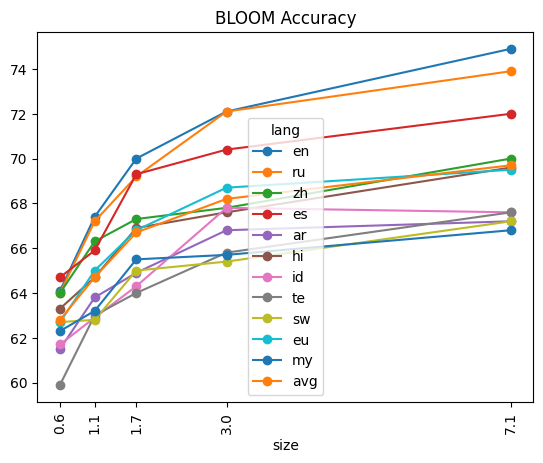

In [52]:
plot_size_df(acc_df_bloom_mt, bloom_model_sizes, bloom_names, "BLOOM MT Accuracy")


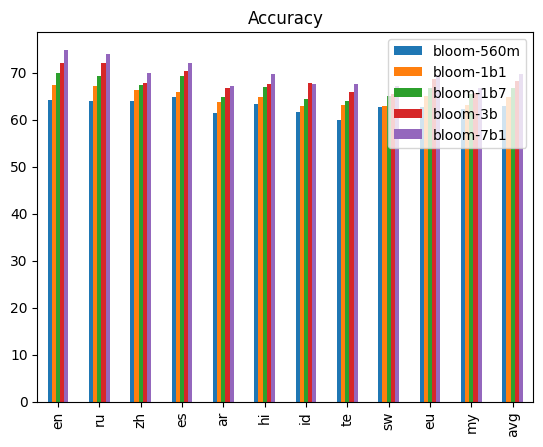

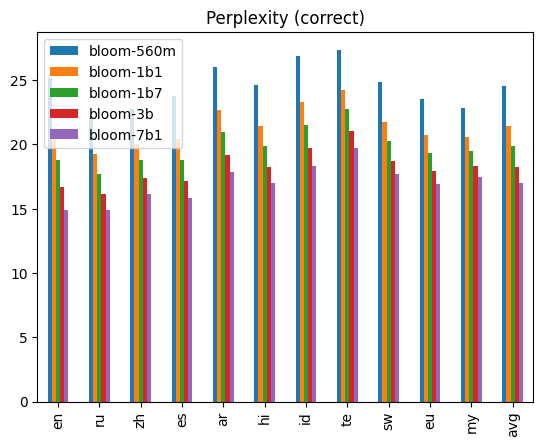

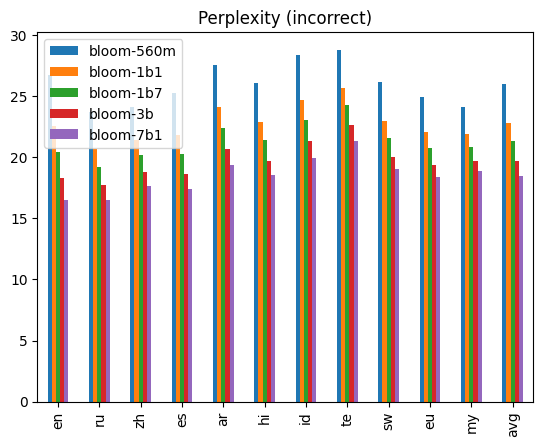

In [53]:
plot_df(acc_df_bloom_mt, "Accuracy")
plot_df(ppl_cor_df_bloom_mt, "Perplexity (correct)")
plot_df(ppl_inc_df_bloom_mt, "Perplexity (incorrect)")


## BLOOMZ

In [54]:
bloomz_model_names = [
    "bigscience/bloomz-560m",
    "bigscience/bloomz-1b1",
    "bigscience/bloomz-1b7",
    "bigscience/bloomz-3b",
    "bigscience/bloomz-7b1",
    "bigscience/bloomz-7b1-mt",
    "bigscience/bloomz-7b1-p3",
]
bloomz_names = [name.split("/")[-1] for name in bloomz_model_names]
bloomz_model_sizes = [0.6, 1.1, 1.7, 3.0, 7.1, 7.1, 7.1]
acc_df_bloomz_mt, ppl_cor_df_bloomz_mt, ppl_inc_df_bloomz_mt = get_dfs(bloomz_model_names, "xstory_cloze_mt_nllb-3B")


In [55]:
display(acc_df_bloomz_mt)
display(ppl_cor_df_bloomz_mt)
display(ppl_inc_df_bloomz_mt)


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,66.0,68.8,72.4,74.4,78.0,78.4,78.1
1,ru,65.8,69.2,71.1,73.1,75.9,76.2,73.9
2,zh,64.5,67.2,68.2,70.2,71.8,71.3,71.5
3,es,65.1,67.6,70.5,72.7,76.0,75.1,74.3
4,ar,62.9,64.8,65.9,67.9,69.0,68.8,69.4
5,hi,62.8,65.5,69.0,69.2,72.4,71.7,72.7
6,id,63.6,65.3,67.4,69.2,71.4,71.1,70.9
7,te,62.5,64.1,66.2,66.2,69.2,69.9,70.4
8,sw,63.6,64.2,66.7,67.1,68.1,67.8,68.2
9,eu,63.9,66.7,68.0,70.0,71.7,71.9,72.2


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,24.69,20.04,18.57,16.90,15.18,15.02,15.97
1,ru,22.33,18.49,17.81,16.63,15.46,15.33,17.60
2,zh,22.70,19.22,18.94,17.96,16.73,16.60,19.10
3,es,23.73,19.73,19.02,17.77,16.43,16.35,18.62
4,ar,26.22,21.87,21.39,20.11,18.70,18.59,21.42
5,hi,24.58,20.71,19.97,18.83,17.59,17.49,18.99
6,id,26.91,22.29,21.83,20.60,18.93,18.88,23.07
7,te,27.36,23.19,22.80,21.77,20.47,20.33,23.50
8,sw,24.52,20.94,20.28,19.27,18.26,18.16,19.39
9,eu,23.98,20.30,19.87,18.94,17.78,17.70,20.65


,lang,bloomz-560m,bloomz-1b1,bloomz-1b7,bloomz-3b,bloomz-7b1,bloomz-7b1-mt,bloomz-7b1-p3
0,en,26.46,21.74,20.43,18.80,17.19,17.04,18.37
1,ru,23.96,20.06,19.58,18.45,17.36,17.23,20.17
2,zh,24.23,20.67,20.55,19.63,18.49,18.37,21.44
3,es,25.36,21.25,20.73,19.53,18.32,18.22,21.18
4,ar,27.92,23.39,23.12,21.86,20.62,20.48,24.06
5,hi,26.15,22.23,21.69,20.56,19.43,19.31,21.28
6,id,28.56,23.85,23.67,22.52,20.89,20.84,25.96
7,te,28.98,24.73,24.56,23.58,22.45,22.29,26.40
8,sw,25.99,22.34,21.81,20.85,19.97,19.86,21.36
9,eu,25.55,21.76,21.52,20.64,19.62,19.51,23.19


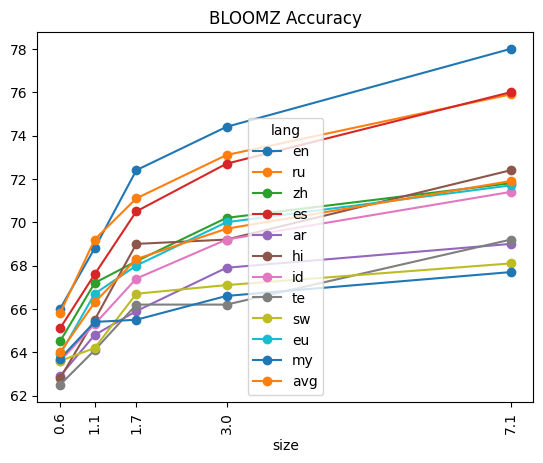

In [56]:
plot_size_df(
    acc_df_bloomz_mt[
        ["lang", "bloomz-560m", "bloomz-1b1", "bloomz-1b7", "bloomz-3b", "bloomz-7b1"]
    ],
    bloomz_model_sizes[:-2],
    bloomz_names[:-2],
    "BLOOMZ Accuracy",
)


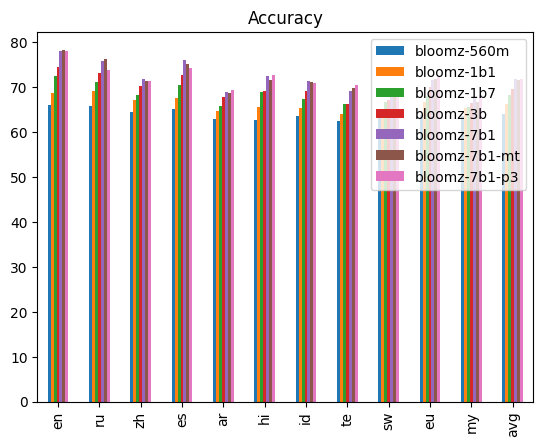

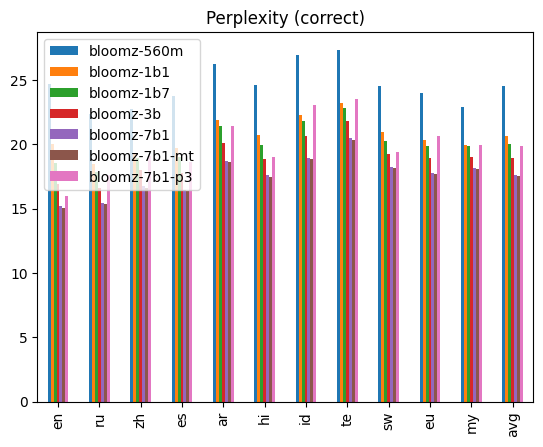

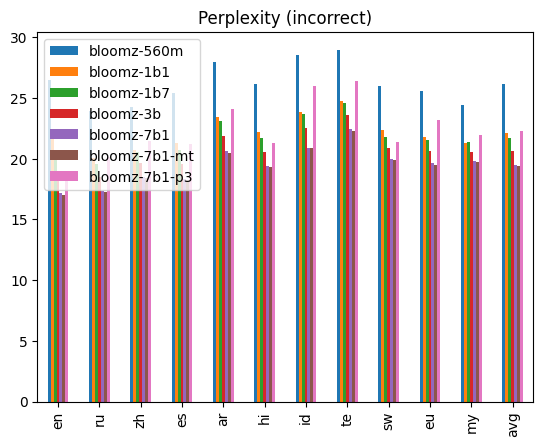

In [57]:
plot_df(acc_df_bloomz_mt, "Accuracy")
plot_df(ppl_cor_df_bloomz_mt, "Perplexity (correct)")
plot_df(ppl_inc_df_bloomz_mt, "Perplexity (incorrect)")


## Summary EU MT

In [69]:
# summarize the eu language results for all models
model_sizes = (
    mgpt_model_sizes
    + xglm_model_sizes
    + bloom_model_sizes
    + bloomz_model_sizes
)

model_names = (
    mgpt_names
    + xglm_names
    + bloom_names
    + bloomz_names
)

models = [name.split("-")[0] for name in model_names]
models[-2] = "bloomz-mt"
models[-1] = "bloomz-p3"

acc_dfs = [acc_df_mgpt_mt, acc_df_xglm_mt, acc_df_bloom_mt, acc_df_bloomz_mt]
ppl_cor_dfs = [
    ppl_cor_df_mgpt_mt,
    ppl_cor_df_xglm_mt,
    ppl_cor_df_bloom_mt,
    ppl_cor_df_bloomz_mt,
]
ppl_inc_dfs = [
    ppl_inc_df_mgpt_mt,
    ppl_inc_df_xglm_mt,
    ppl_inc_df_bloom_mt,
    ppl_inc_df_bloomz_mt,
]

acc_eu, ppl_cor_eu, ppl_inc_eu = [], [], []
for df in acc_dfs:
    acc_eu.extend(df.loc[df["lang"] == "eu"].values[0][1:])
for df in ppl_cor_dfs:
    ppl_cor_eu.extend(df.loc[df["lang"] == "eu"].values[0][1:])
for df in ppl_inc_dfs:
    ppl_inc_eu.extend(df.loc[df["lang"] == "eu"].values[0][1:])

results_eu_mt_df = pd.DataFrame({"model_name": model_names, "model": models, "size": model_sizes, "acc": acc_eu, "ppl_cor": ppl_cor_eu, "ppl_inc": ppl_inc_eu})

In [70]:
results_eu_mt_df

,model_name,model,size,acc,ppl_cor,ppl_inc
0,mGPT,mGPT,1.3,61.2,19.41,20.41
1,xglm-564M,xglm,0.6,60.8,20.39,21.29
2,xglm-1.7B,xglm,1.7,64.3,17.80,18.84
3,xglm-2.9B,xglm,2.9,66.2,16.94,18.07
4,xglm-4.5B,xglm,4.5,66.0,16.39,17.54
5,xglm-7.5B,xglm,7.5,66.6,16.25,17.43
6,bloom-560m,bloom,0.6,62.7,23.53,24.94
7,bloom-1b1,bloom,1.1,65.0,20.72,22.09
8,bloom-1b7,bloom,1.7,66.8,19.32,20.74
9,bloom-3b,bloom,3.0,68.7,17.96,19.40


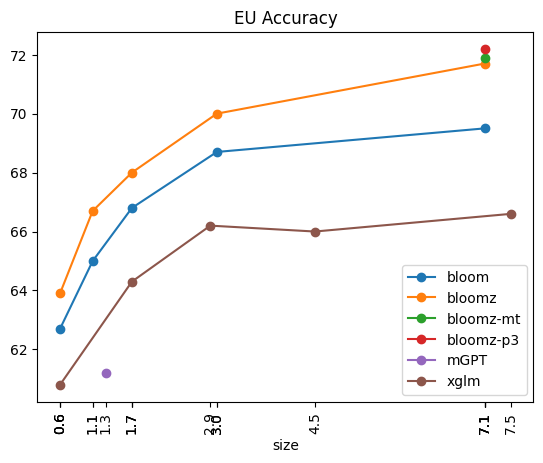

In [71]:
results_eu_mt_df.set_index("size", inplace=True)
results_eu_mt_df.groupby("model")["acc"].plot(x="size", y="acc", title="EU MT Accuracy", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

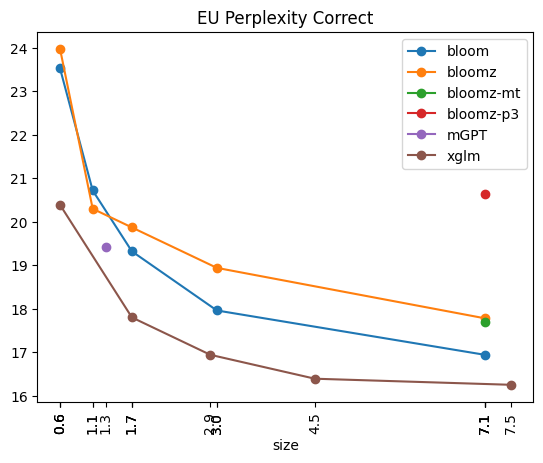

In [72]:
results_eu_mt_df.groupby("model")["ppl_cor"].plot(x="size", y="ppl_cor", title="EU MT Perplexity Correct", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

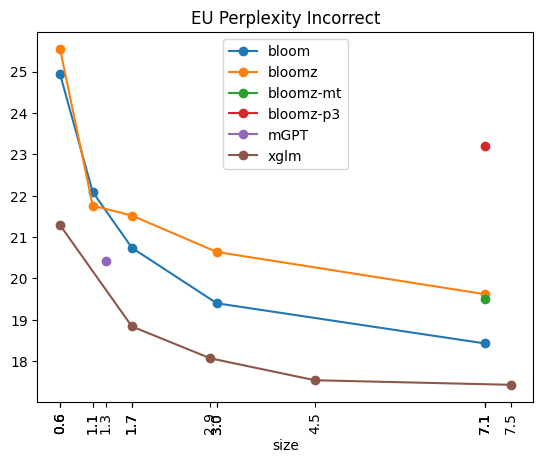

In [73]:
results_eu_mt_df.groupby("model")["ppl_inc"].plot(x="size", y="ppl_inc", title="EU MT Perplexity Incorrect", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

## Summary AVG MT

In [74]:
model_sizes = (
    mgpt_model_sizes
    + xglm_model_sizes
    + bloom_model_sizes
    + bloomz_model_sizes
)

model_names = (
    mgpt_names
    + xglm_names
    + bloom_names
    + bloomz_names
)

models = [name.split("-")[0] for name in model_names]
models[-2] = "bloomz-mt"
models[-1] = "bloomz-p3"

acc_dfs = [acc_df_mgpt_mt, acc_df_xglm_mt, acc_df_bloom_mt, acc_df_bloomz_mt]
ppl_cor_dfs = [
    ppl_cor_df_mgpt_mt,
    ppl_cor_df_xglm_mt,
    ppl_cor_df_bloom_mt,
    ppl_cor_df_bloomz_mt,
]
ppl_inc_dfs = [
    ppl_inc_df_mgpt_mt,
    ppl_inc_df_xglm_mt,
    ppl_inc_df_bloom_mt,
    ppl_inc_df_bloomz_mt,
]

acc_eu, ppl_cor_eu, ppl_inc_eu = [], [], []
for df in acc_dfs:
    acc_eu.extend(df.loc[df["lang"] == "avg"].values[0][1:])
for df in ppl_cor_dfs:
    ppl_cor_eu.extend(df.loc[df["lang"] == "avg"].values[0][1:])
for df in ppl_inc_dfs:
    ppl_inc_eu.extend(df.loc[df["lang"] == "avg"].values[0][1:])

results_avg_mt_df = pd.DataFrame({"model_name": model_names, "model": models, "size": model_sizes, "acc": acc_eu, "ppl_cor": ppl_cor_eu, "ppl_inc": ppl_inc_eu})

In [75]:
results_avg_mt_df

,model_name,model,size,acc,ppl_cor,ppl_inc
0,mGPT,mGPT,1.3,61.6,20.28,21.28
1,xglm-564M,xglm,0.6,60.3,21.26,22.18
2,xglm-1.7B,xglm,1.7,63.7,18.32,19.39
3,xglm-2.9B,xglm,2.9,65.9,17.22,18.40
4,xglm-4.5B,xglm,4.5,66.6,16.63,17.83
5,xglm-7.5B,xglm,7.5,67.5,16.44,17.67
6,bloom-560m,bloom,0.6,62.8,24.55,26.01
7,bloom-1b1,bloom,1.1,64.7,21.40,22.81
8,bloom-1b7,bloom,1.7,66.7,19.85,21.33
9,bloom-3b,bloom,3.0,68.2,18.24,19.73


In [76]:
results_avg_mt_df.set_index("size", inplace=True)

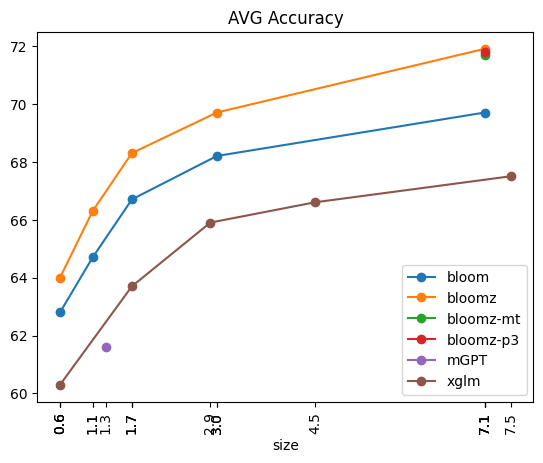

In [77]:
results_avg_mt_df.groupby("model")["acc"].plot(x="size", y="acc", title="AVG MT Accuracy", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

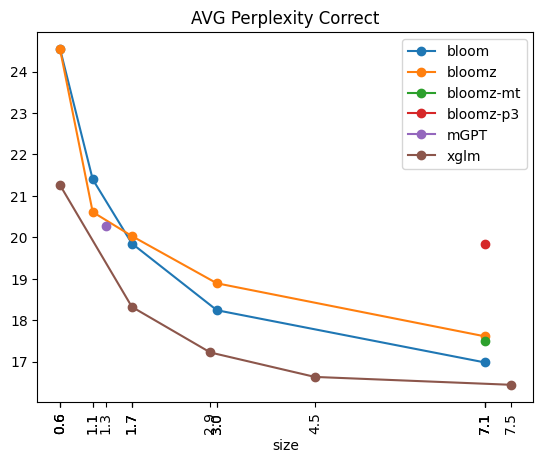

In [78]:
results_avg_mt_df.groupby("model")["ppl_cor"].plot(x="size", y="ppl_cor", title="AVG MT Perplexity Correct", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");

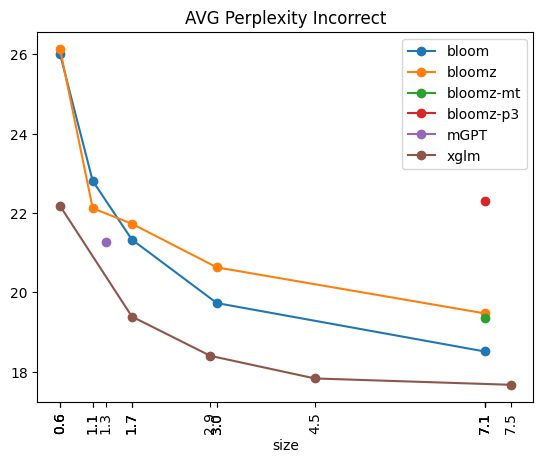

In [79]:
results_avg_mt_df.groupby("model")["ppl_inc"].plot(x="size", y="ppl_inc", title="AVG MT Perplexity Incorrect", legend=True, marker="o");
plt.xticks(model_sizes, model_sizes, rotation="vertical");